# Using Deep Learning to Classify Simulated Galaxy Images

Adapted from: https://archive.stsci.edu/hello-universe/deepmerge.

# Images from James Webb Space Telescope

Recently, we have gotten phenomenal pictures from the James Webb Space Telescope (JWST) of very distant galaxies. Here are some of the more eye-catching ones:

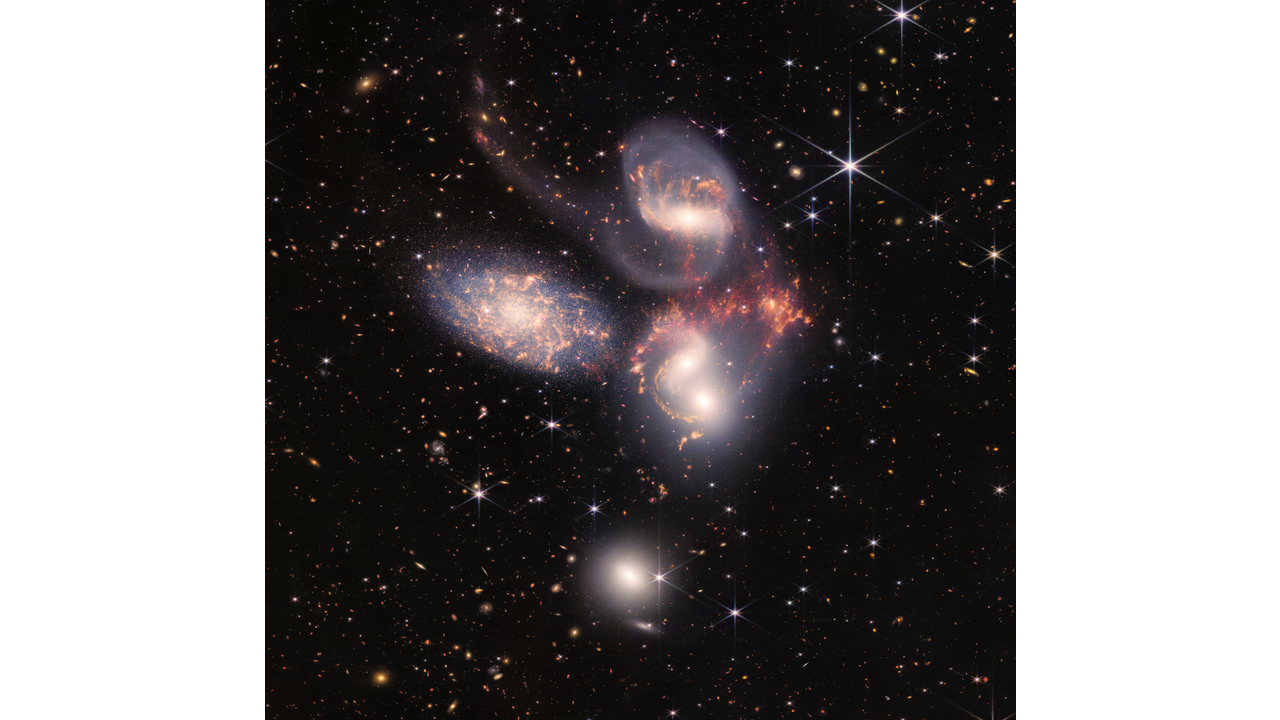

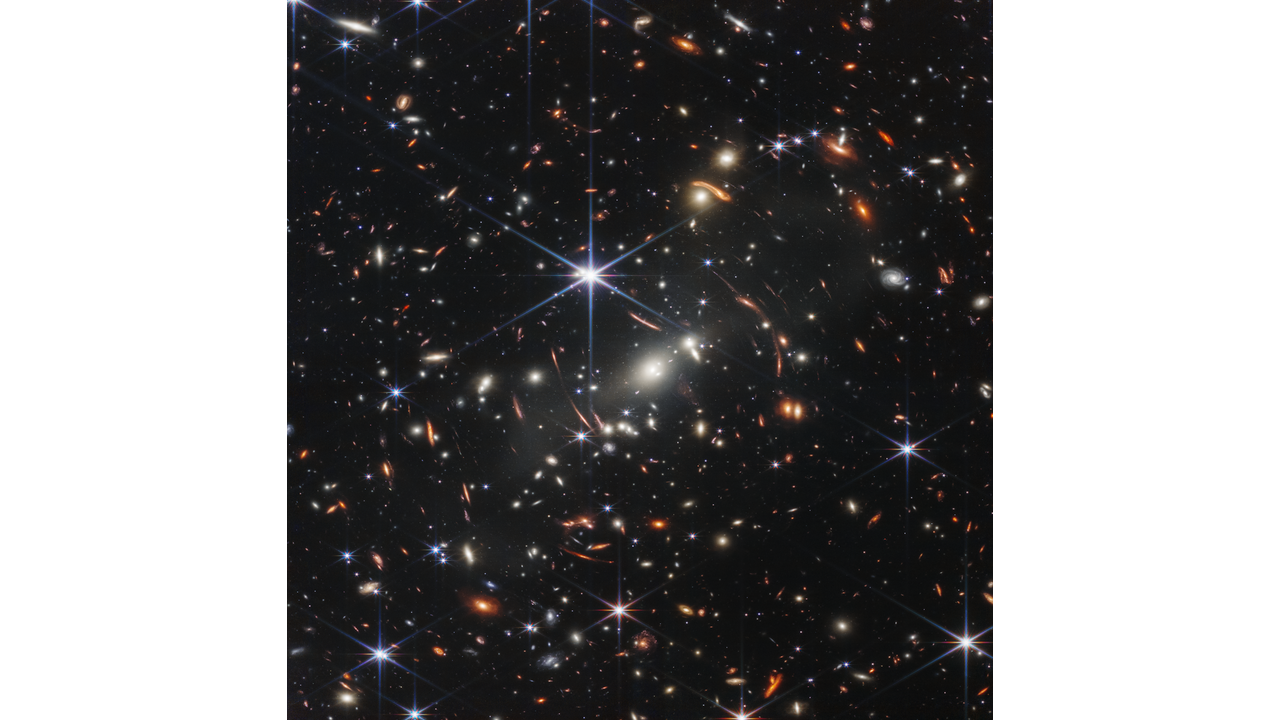

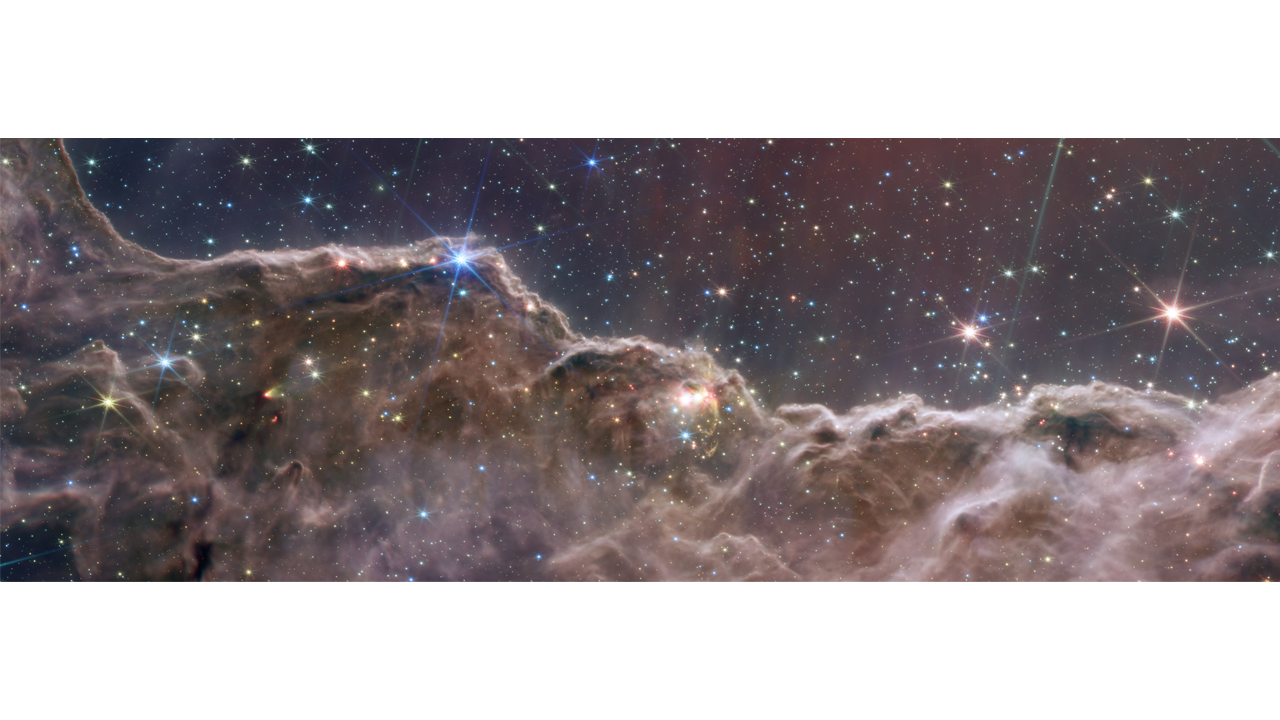

Before we had real pictures, though, astronomers simulated galaxies that JWST might see in order to understand how different analysis choices would affect inferences made from upcoming images. We are going to be using some of these simulated images to train a neural network to "learn" different properties about these simulated images. Specifically, some of the galaxies in our images are "merging" (meaning two galaxies are combining to make a single, larger galaxy), or "not merging". We want to be able to (accurately!) tell which is which.

To do this, we're going to build a convolutional neural network (CNN), which is excellent for image-based tasks like this one. First we will download and explore the data, then we will train the network, then we will measure how good of a job the network did.

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
# define which version of the data to use for training
version = "pristine"

In [3]:
%%time
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-' + version + '.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

CPU times: user 4.25 s, sys: 5.74 s, total: 9.99 s
Wall time: 49.2 s


In [4]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   75                                                  
NAXIS2  =                   75                                                  
NAXIS3  =                    3                                                  
NAXIS4  =                15426                                                  
EXTEND  =                    T                                                  
NAME1   = 'ImageX  '                                                            
NAME2   = 'ImageY  '                                                            
NAME3   = 'filter  '           / F814W,F356W,F160W                              
NAME4   = 'object  '                                                            
EXTNAME = 'Images  '        

In [5]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                15426 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'MergerLabel'                                                         
TFORM1  = 'D       '                                                            
EXTNAME = 'MergerLabel'                                                         

In [6]:
hdu[0].data.shape

(15426, 3, 75, 75)

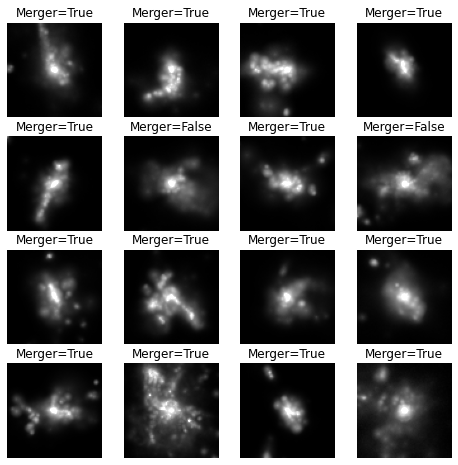

In [7]:
example_ids = np.random.choice(hdu[1].data.shape[0], 16)
examples = [hdu[0].data[j, 1, :, :] for j in example_ids]

fig = plt.figure(figsize=(8, 8))

for i, image in enumerate(examples):
  ax = fig.add_subplot(4, 4, i + 1)
  norm = simple_norm(image, "log", max_percent=99.75)

  ax.imshow(image, aspect="equal", cmap="binary_r", norm=norm)
  ax.set_title("Merger=" + str(bool(hdu[1].data[example_ids[i]][0])))

  ax.axis("off")

plt.show()

In [8]:
X = hdu[0].data
y = hdu[1].data

In [9]:
random_state = 42
X = np.asarray(X).astype("float32")
y = np.asarray(y).astype("float32")

X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [10]:
imsize = np.shape(X_train)[2]

X_train = X_train.reshape(-1, imsize, imsize, 3)
X_valid = X_valid.reshape(-1, imsize, imsize, 3)
X_test = X_test.reshape(-1, imsize, imsize, 3)

In [11]:
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation="relu", strides=(1, 1), padding="same")(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation="relu", strides=(1, 1), padding="same")(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation="relu", strides=(1, 1), padding="same")(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation="softmax", kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation="softmax", kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation="sigmoid")(z1)

cnn = Model(inputs=x_in, outputs=y_out)

In [12]:
optimizer = "adam"
fit_metrics = ["accuracy"]
loss = "binary_crossentropy"
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 37, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 16)        1168  

In [13]:
nb_epoch = 20
batch_size = 128
shuffle = True

history = cnn.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_valid, y_valid),
    shuffle=shuffle,
    verbose=False,
)

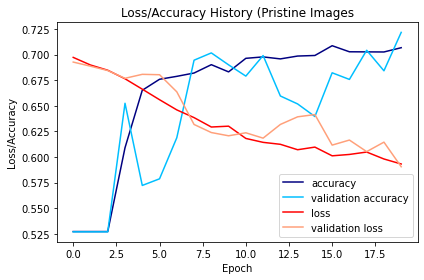

In [14]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, "navy", label="accuracy")
plot1_val_lacc = axis1.plot(epochs, val_acc, "deepskyblue", label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, "red", label="loss")
plot1_val_loss = axis1.plot(epochs, val_loss, "lightsalmon", label="validation loss")

plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel("Epoch")
axis1.set_ylabel("Loss/Accuracy")
plt.title("Loss/Accuracy History (Pristine Images")
plt.tight_layout()
axis1.legend(loc="lower right")
plt.show()

In [15]:
test_predictions = cnn.predict(X_test)

In [16]:
def plot_confusion_matrix(cnn, input_data, input_labels):
  predictions = cnn.predict(input_data)

  predictions = (predictions > 0.5).astype("int32")

  cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
  cm = cm.astype("float")

  cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  fig = plt.figure()
  ax = fig.add_subplot(111)

  ax.matshow(cm_norm, cmap="binary_r")

  plt.title("Confusion matrix", y=1.08)

  ax.set_xticks([0, 1])
  ax.set_xticklabels(["Merger", "No Merger"])
  ax.set_yticks([0, 1])
  ax.set_yticklabels(["Merger", "No Merger"])

  plt.xlabel("Predicted")
  plt.ylabel("True")

  fmt = "0.2f"
  thresh = cm_norm.max() / 2.0
  for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
      ax.text(
          j,
          i,
          format(
            cm_norm[i, j], fmt
          ),
          ha="center",
          va="center",
          color="white" if cm_norm[i, j] < thresh else "black",
      )
  plt.show()

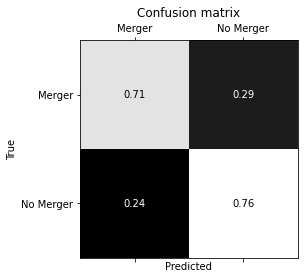

In [17]:
plot_confusion_matrix(cnn, X_test, y_test)